## imports

In [1]:
import pandas as pd
import seaborn as sns
import os
import numpy as np

## feature engineering / data wrangling 

### merging

In [2]:
weekdays = ['monday','tuesday','wednesday','thursday','friday']

df_list = []

for i in weekdays:
    df_list.append(pd.read_csv('data/'+i+'.csv', delimiter =';'))

df = pd.concat(df_list).reset_index()

### custom features

In [3]:
df['weekday'] = df["timestamp"].apply(lambda x: pd.to_datetime(x).weekday()) 
df['time'] = df["timestamp"].apply(lambda x: pd.to_datetime(x).hour)
df['minute'] = df["timestamp"].apply(lambda x: pd.to_datetime(x).minute)
df['abs_minute'] = df['minute'] + 60 * df['time']
df['customer_no'] = df['customer_no'] + 10000 * df['weekday']

In [4]:
visited = []

def first_section(x):
    if x not in visited:
        visited.append(x)
        return 1
    else:
        return 0    

In [5]:
df['first_section'] = df['customer_no'].apply(first_section)

In [6]:
df = df.set_index('index')
df.head(10)

,timestamp,customer_no,location,weekday,time,minute,abs_minute,first_section
index,,,,,,,,
0,2019-09-02 07:03:00,1,dairy,0,7,3,423,1
1,2019-09-02 07:03:00,2,dairy,0,7,3,423,1
2,2019-09-02 07:04:00,3,dairy,0,7,4,424,1
3,2019-09-02 07:04:00,4,dairy,0,7,4,424,1
4,2019-09-02 07:04:00,5,spices,0,7,4,424,1
5,2019-09-02 07:04:00,6,spices,0,7,4,424,1
6,2019-09-02 07:04:00,7,spices,0,7,4,424,1
7,2019-09-02 07:04:00,8,fruit,0,7,4,424,1
8,2019-09-02 07:05:00,1,checkout,0,7,5,425,0


In [7]:
df.to_csv('data/clean.csv')

## data exploration

### number of customers

In [8]:
len(df['customer_no'].unique())

7445

### number of customers per day

<AxesSubplot:xlabel='weekday', ylabel='count'>

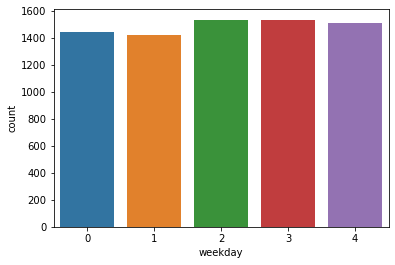

In [9]:
df_weekday_count = pd.DataFrame(df.groupby('weekday')['customer_no'].unique())
df_weekday_count['count'] = df_weekday_count['customer_no'].apply(lambda x: len(x))

sns.barplot(data = df_weekday_count.reset_index(), x = 'weekday', y = 'count')

### number of customers in each section

<AxesSubplot:xlabel='0', ylabel='1'>

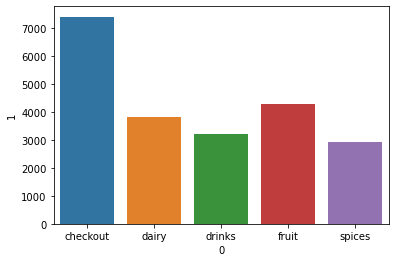

In [10]:
sections = sorted(df['location'].unique())#

section_customer_count = []

for i, x in enumerate(sections):
    section_customer_count.append([x, len(df.groupby('location')['customer_no'].unique()[i])])

sns.barplot(data = pd.DataFrame(section_customer_count), x = 0, y = 1)    

### number of customers in each section over time

In [11]:
df_section_time = pd.DataFrame(df.groupby(['location','time'])['customer_no'].unique())
df_section_time = df_section_time.reset_index()
df_section_time['count'] = df_section_time['customer_no'].apply(lambda x: len(x))
df_section_time.head(3)

,location,time,customer_no,count
0,checkout,7,"[1, 5, 2, 3, 8, 4, 10, 11, 14, 12, 16, 15, 7, ...",454
1,checkout,8,"[98, 101, 97, 102, 80, 84, 99, 100, 105, 106, ...",677
2,checkout,9,"[203, 212, 215, 192, 208, 167, 216, 218, 199, ...",455


<AxesSubplot:xlabel='time', ylabel='count'>

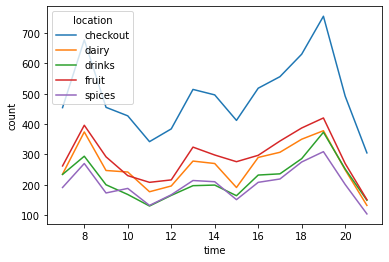

In [12]:
sns.lineplot(data = df_section_time, x = 'time', y='count', hue = 'location')

### time each customer spend in supermarket

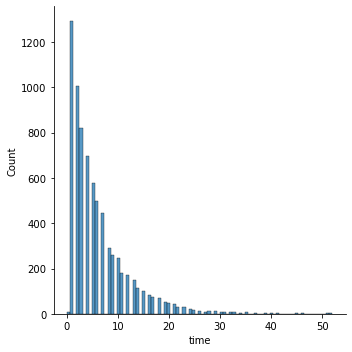

In [13]:
time_spend = []

for i in df['customer_no'].unique():
    time_spend.append(df[(df['customer_no'] == i)]['abs_minute'].max() 
                      - df[(df['customer_no'] == i)]['abs_minute'].min())
    
df_time_spend = pd.DataFrame(df['customer_no'].unique(), time_spend).reset_index()#.set_index(0)
df_time_spend.columns = ['time','customer_no']
df_time_spend.head(3)
sns.displot(df_time_spend['time'])

## crosstab

In [17]:
df_transitions = pd.DataFrame()

for i in df['customer_no'].unique():
    transition = df[(df['customer_no'] == i)][['location']]
    transition['location_after'] = transition['location'].shift(-1)
    transition.dropna(inplace=True)
    transition['customer_no'] = i
    df_transitions = df_transitions.append(transition)

df_transitions.head(15)

,location,location_after,customer_no
0,dairy,checkout,1
1,dairy,checkout,2
2,dairy,checkout,3
3,dairy,checkout,4
4,spices,checkout,5
5,spices,dairy,6
10,dairy,spices,6
62,spices,drinks,6
71,drinks,spices,6
102,spices,dairy,6


In [15]:
cross = pd.crosstab(df_transitions['location_after'], df_transitions['location'], normalize=1)
cross

location,dairy,drinks,fruit,spices
location_after,,,,
checkout,0.391211,0.537023,0.499511,0.251000
dairy,0.000000,0.027159,0.238319,0.323553
drinks,0.223151,0.000000,0.136266,0.273140
fruit,0.189925,0.219062,0.000000,0.152307
spices,0.195713,0.216756,0.125904,0.000000


In [16]:
cross.to_csv('data/crosstab.csv')